# Imports

In [1]:
import torch
import os
from tqdm import tqdm
import numpy as np
import imageio
import math
import matplotlib.pyplot as plt
import pandas as pd

import metaras

# Original

In [2]:
def iou_loss(predict, target):
    dims = tuple(range(predict.ndimension())[1:])
    intersect = (predict * target).sum(dims)
    union = (predict + target - predict * target).sum(dims) + 1e-6
    return (1. - intersect / union).sum()

def mse_loss(predict, target):
    return (predict - target).pow(2).sum(0).mean()

def perspective(vertices, angle=30.):
    if (vertices.ndimension() != 3):
        raise ValueError('vertices Tensor should have 3 dimensions')
    device = vertices.device
    # angle = torch.tensor(angle / 180 * math.pi, dtype=torch.float32, device=device)
    angle = (angle / 180 * math.pi).clone().detach().to(device).type(torch.float32)
    width = torch.tan(angle)
    width = width.unsqueeze(-1)
    z = vertices[:, :, 2]
    x = vertices[:, :, 0] / z / width
    y = vertices[:, :, 1] / z / width
    vertices = torch.stack((x, y, z), dim=2)
    return vertices

def transform_cameras(mesh, poses, additional_poses=None):

    new_vertices = mesh.vertices.clone()

    if additional_poses is not None:
        additional_eyes = metaras.functional.get_points_from_angles(additional_poses[:, 0], additional_poses[:, 1],
                                                     additional_poses[:, 2], degrees=True)
        new_vertices = metaras.functional.look_at(new_vertices, additional_eyes, only_rotate=True)

    eyes = metaras.functional.get_points_from_angles(poses[:, 0], poses[:, 1], poses[:, 2], degrees=True)
    new_vertices = metaras.functional.look_at(new_vertices, eyes)
    new_vertices = perspective(new_vertices, poses[:, 3])

    return metaras.Mesh(new_vertices, mesh.faces.clone(),
                   mesh.textures.clone() if mesh.textures is not None else None, mesh.texture_res, mesh.texture_type)

def render(mesh, poses, renderer, additional_poses=None):
    mesh_ = lighting(mesh)
    mesh_ = transform_cameras(mesh_, poses, additional_poses=additional_poses)
    return renderer(mesh_)

def make_grid(input1, input2, grid_x, grid_y, successes=None):
    input1 = input1.detach().cpu().numpy()
    input2 = input2.detach().cpu().numpy()

    img = []
    j = 0
    for y in range(grid_y):
        row = []
        for x in range(grid_x):
            row.append(input1[j].transpose((1, 2, 0)))
            row.append(input2[j].transpose((1, 2, 0)))
            # row.append(input1[j][3])
            # row.append(input1[j][0:3]) #shading
            if successes is not None and successes[j]:
                row[-1][0, :] = 1.
                row[-1][:, 0] = 1.
                row[-1][-1, :] = 1.
                row[-1][:, -1] = 1.
            # row.append(input2[j][0:3])
            j += 1
        row = np.concatenate(row, 1)
        img.append(row)
    img = np.concatenate(img, 0)
    return (255*img).astype(np.uint8)

plot_renderer = metaras.MetaRas(
    image_size=256,
    dist_func=0,
    dist_scale=1e-4,
    dist_squared=True,
    dist_shape=0.,
    dist_shift=0.,
    dist_eps=1,
    aggr_alpha_func=0,
    aggr_alpha_t_conorm_p=0.,
    aggr_rgb_func='hard',
)
seed = 0
device = 'cuda'
model_obj = 'spot.obj'
batch_size = 1
lighting = metaras.Lighting()
mesh_location = os.path.join('data/pose', model_obj)
mesh = metaras.Mesh.from_obj(mesh_location,load_texture=True, texture_res=5, texture_type='surface')
mesh = metaras.Mesh(mesh.vertices.repeat(batch_size, 1, 1), mesh.faces.repeat(batch_size, 1, 1),textures=mesh.textures, texture_res=5, texture_type='surface')
torch.manual_seed(seed)
poses_gt = torch.nn.Parameter(torch.zeros(batch_size, 4).float().to(device))
poses_gt.data[:, 0] = 2.5 + 0.5*torch.ones(batch_size) * 1.5
poses_gt.data[:, 1] = 0.5*torch.ones(batch_size) * 60
poses_gt.data[:, 2] = 0.5*torch.ones(batch_size) * 60
poses_gt.data[:, 3] = 20.

with torch.no_grad():
    images_ref = render(mesh, poses_gt, plot_renderer)

(-0.5, 255.5, 255.5, -0.5)

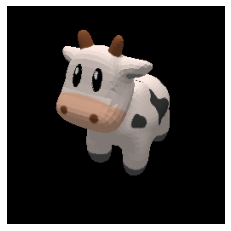

In [3]:
plt.imshow(images_ref[0].cpu().detach().numpy().transpose(1,2,0)[:,:,:3])
plt.axis('off')

## MLP

In [4]:
device = 'cuda'
aggr_func = 'probabilistic'
squared = False
dist_shape = 0.0
dist_shift = 0.0
t_conorm_p = 0.0
losses = ['iou']
dist_eps = 100
gif = True
seed = 0
batch_size = 24
image_size = 64#256
mesh_location = os.path.join('data/pose', model_obj)
num_steps = 300
optimizer_choice = 'adam'
learning_rate = 0.3

learning_rate_meta = 0.03

dist_func = 'mlp'
w1 = torch.nn.Parameter(torch.rand([4*1]).to(device))
w2 = torch.nn.Parameter(torch.rand([4*4]).to(device))
w3 = torch.nn.Parameter(torch.rand([4*4]).to(device))
w4 = torch.nn.Parameter(torch.rand([4*4]).to(device))
w5 = torch.nn.Parameter(torch.rand([1*4]).to(device))

####################################################################################################################

lighting = metaras.Lighting()
diff_renderer = metaras.MetaRas(
    image_size=image_size,
    dist_func=dist_func,
    dist_scale=torch.nn.Parameter(torch.tensor([-4.]).to(device)),
    dist_scale_rgb=torch.nn.Parameter(torch.tensor([-4.]).to(device)),
    dist_squared=squared,
    dist_shape=dist_shape,
    dist_shift=dist_shift,
    dist_eps=dist_eps,
    aggr_alpha_func=aggr_func,
    aggr_alpha_t_conorm_p=t_conorm_p,
    aggr_rgb_func='hard',
    w1=w1,
    w2=w2,
    w3=w3,
    w4=w4,
    w5=w5,
)
hard_renderer = metaras.MetaRas(
    image_size=image_size,
    dist_func=0,
    dist_scale=torch.tensor([-4.]).to(device),
    dist_squared=True,
    dist_shape=0.,
    dist_shift=0.,
    dist_eps=10,
    aggr_alpha_func=0,
    aggr_alpha_t_conorm_p=0.,
    aggr_rgb_func='hard',
)

res_directory = f'data/pose/original_{diff_renderer.dist_func}'
try:
    os.makedirs(res_directory)
except:
    print("directory exists")

mesh = metaras.Mesh.from_obj(mesh_location,load_texture=True, texture_res=5, texture_type='surface')
mesh = metaras.Mesh(mesh.vertices.repeat(batch_size, 1, 1), mesh.faces.repeat(batch_size, 1, 1),textures=mesh.textures, texture_res=5, texture_type='surface')

torch.manual_seed(seed)

if gif:
    poses_gt = torch.nn.Parameter(torch.zeros(batch_size, 4).float().to(device))
    poses_gt.data[:, 0] = 2.5 + torch.rand(batch_size) * 1.5
    poses_gt.data[:, 1] = torch.randn(batch_size) * 60
    poses_gt.data[:, 2] = torch.randn(batch_size) * 60
    poses_gt.data[:, 3] = 20.
else:
    poses_gt = torch.nn.Parameter(torch.zeros(batch_size, 4).float().to(device))
    poses_gt.data[:, 0] = 2.5 + 0.5*torch.ones(batch_size) * 1.5
    poses_gt.data[:, 1] = 0.5*torch.ones(batch_size) * 60
    poses_gt.data[:, 2] = 0.5*torch.ones(batch_size) * 60
    poses_gt.data[:, 3] = 20.

print('Generating goals...')
with torch.no_grad():
    goal = render(mesh, poses_gt, hard_renderer)
    
    # uncomment to save the goals
    # directory = f'data/pose/original_ref'
    # try:
    #     os.makedirs(directory)
    # except:
    #     print("directory exists")
    # for i in range(24):
    #     plt.axis("off")
    #     plt.imshow(goal[i].cpu().detach().numpy().transpose(1,2,0)[:,:,:3])
    #     plt.savefig(f'{directory}/ref_{i}.pdf',bbox_inches='tight',pad_inches=0.0)
    #     plt.clf()
    
####################################################################################################################

threshold = 5

####################################################################################################################

initial_angles = [
    (15, 35),
#     (35, 55),
#     (55, 75),
]

####################################################################################################################

for initial_angle_min, initial_angle_max in initial_angles:
    for loss_fn in losses:
        grid_x = 4
        grid_y = 6
        setting = 'a{aa}-{ab}-l{l}'.format(
            aa=initial_angle_min,
            ab=initial_angle_max,
            l=loss_fn,
        )

        diff_renderer.w1 = torch.nn.Parameter(torch.rand([4*1]).to(device))
        diff_renderer.w2 = torch.nn.Parameter(torch.rand([4*4]).to(device))
        diff_renderer.w3 = torch.nn.Parameter(torch.rand([4*4]).to(device))
        diff_renderer.w4 = torch.nn.Parameter(torch.rand([4*4]).to(device))
        diff_renderer.w5 = torch.nn.Parameter(torch.rand([1*4]).to(device))
        
        loop = tqdm(range(num_steps))
        torch.manual_seed(seed+1)
        
        if gif:
            poses = torch.nn.Parameter(torch.zeros(batch_size, 4).float().to(device))
            poses.data[:, 0] = 2. + torch.rand(batch_size) * 8.
            poses.data[:, 1] = torch.randn(batch_size)
            poses.data[:, 2] = torch.randn(batch_size)
            angles = torch.sqrt(poses.data[:, 1] ** 2 + poses.data[:, 2] ** 2)
            initial_angle = initial_angle_min + torch.rand(batch_size).to(device) * (initial_angle_max - initial_angle_min)
            poses.data[:, 1] = poses.data[:, 1] * initial_angle / angles
            poses.data[:, 2] = poses.data[:, 2] * initial_angle / angles
            poses.data[:, 3] = 10. + torch.rand(batch_size) * 20.
        else:
            random_weight = 0.6
            poses = torch.nn.Parameter(torch.zeros(batch_size, 4).float().to(device))
            poses.data[:, 0] = 2. + random_weight*torch.ones(batch_size) * 8.
            poses.data[:, 1] = random_weight*torch.ones(batch_size)
            poses.data[:, 2] = random_weight*torch.ones(batch_size)
            angles = torch.sqrt(poses.data[:, 1] ** 2 + poses.data[:, 2] ** 2)
            initial_angle = initial_angle_min + random_weight*torch.ones(batch_size).to(device) * (initial_angle_max - initial_angle_min)
            poses.data[:, 1] = poses.data[:, 1] * initial_angle / angles
            poses.data[:, 2] = poses.data[:, 2] * initial_angle / angles
            poses.data[:, 3] = 10. + random_weight*torch.ones(batch_size) * 20.
        
        if optimizer_choice == 'adam':
            optim = torch.optim.Adam([{"params": poses, "lr": learning_rate},
                                        {"params": diff_renderer.w1, "lr": learning_rate_meta},
                                        {"params": diff_renderer.w2, "lr": learning_rate_meta},
                                        {"params": diff_renderer.w3, "lr": learning_rate_meta},
                                        {"params": diff_renderer.w4, "lr": learning_rate_meta},
                                        {"params": diff_renderer.w5, "lr": learning_rate_meta}], betas=(0.9, 0.99))
        elif optimizer_choice == 'sgd':
            optim = torch.optim.SGD([{"params": poses, "lr": learning_rate},
                                        {"params": diff_renderer.w1, "lr": learning_rate_meta},
                                        {"params": diff_renderer.w2, "lr": learning_rate_meta},
                                        {"params": diff_renderer.w3, "lr": learning_rate_meta},
                                        {"params": diff_renderer.w4, "lr": learning_rate_meta},
                                        {"params": diff_renderer.w5, "lr": learning_rate_meta}])
        else:
            raise ValueError(optimizer_choice)
        
        if gif:
            writer = imageio.get_writer('data/pose/original_{}_{}_{}.gif'.format(
                setting, model_obj.split('.')[0], diff_renderer.dist_func
            ), mode='I')
            
        history_loss = []
        history_params = []
        
        for i in loop:
            pred = render(mesh, poses, diff_renderer, additional_poses=poses_gt)
            
            # uncomment to save init
            # if i == 0:
            #     directory = f'data/pose/original_init'
            #     try:
            #         os.makedirs(directory)
            #     except:
            #         print("directory exists")
            #     for i in range(24):
            #         plt.axis("off")
            #         plt.imshow(pred[i].cpu().detach().numpy().transpose(1,2,0)[:,:,:3])
            #         plt.savefig(f'{directory}/init_{i}.pdf',bbox_inches='tight',pad_inches=0.0)
            #         plt.clf()
            
            loss = (mse_loss if loss_fn == 'mse' else iou_loss)(pred[:, 3], goal[:, 3])
            optim.zero_grad()
            loss.backward()
            optim.step()

            if loss.isnan():
                print('Stopping the loop because loss is NaN.')
                break
            if gif:
                if i % 20 == 0:
                    successes = poses.data[:, 1] ** 2 + poses.data[:, 2] ** 2 < threshold ** 2
                    writer.append_data(make_grid(pred, goal, grid_x, grid_y, successes))
            
            history_loss.append(loss.item())
            
            point_gt = metaras.functional.get_points_from_angles(torch.ones_like(poses_gt[:, 0]), torch.zeros_like(poses_gt[:, 1]),torch.zeros_like(poses_gt[:, 2]), degrees=True)
            point = metaras.functional.get_points_from_angles(torch.ones_like(poses[:, 0]), poses[:, 1],poses[:, 2], degrees=True)
            history_params.append(mse_loss(point,point_gt).item())
            
        successes = poses.data[:, 1] ** 2 + poses.data[:, 2] ** 2 < threshold ** 2
        print({'{}_success_{}'.format(setting, threshold): successes.float().mean().item()})

        pd_mlp_loss = pd.DataFrame(np.array(history_loss))
        pd_mlp_loss.to_csv(f"{res_directory}/loss_silhouette_{setting}_{model_obj.replace('.obj','')}.csv",header=None,index=False)

        pd_mlp_loss = pd.DataFrame(np.array(history_params))
        pd_mlp_loss.to_csv(f"{res_directory}/loss_param_{setting}_{model_obj.replace('.obj','')}.csv",header=None,index=False)

        torch.save(diff_renderer._parameters, f"{res_directory}/{setting}_{model_obj.replace('.obj','')}.pth")

for i in range(24):
    plt.axis("off")
    plt.imshow(pred[i].cpu().detach().numpy().transpose(1,2,0)[:,:,:3])
    plt.savefig(f'{res_directory}/{diff_renderer.dist_func}_{i}.pdf',bbox_inches='tight',pad_inches=0.0)
    plt.clf()

directory exists
Generating goals...


100%|██████████| 300/300 [00:28<00:00, 10.63it/s]


{'a15-35-liou_success_5': 1.0}


<Figure size 432x288 with 0 Axes>

## Softs

In [5]:
device = 'cuda'
aggr_func = 'probabilistic'
squared = False
dist_shape = 0.0
dist_shift = 0.0
t_conorm_p = 0.0
losses = ['iou']
dist_eps = 100
gif = True
seed = 0
batch_size = 24
image_size = 64#256
mesh_location = os.path.join('data/pose', model_obj)
num_steps = 300
optimizer_choice = 'adam'
learning_rate = 0.3

# funcs = ['gaussian', 'logistic', 'exponential_rev', 'gamma_rev']
funcs = ['gamma_rev']
dist_shape = 0.5


for dist_func in funcs:
####################################################################################################################

    lighting = metaras.Lighting()
    diff_renderer = metaras.MetaRas(
        image_size=image_size,
        dist_func=dist_func,
        dist_scale=torch.nn.Parameter(torch.tensor([-4.]).to(device)),
        dist_scale_rgb=torch.nn.Parameter(torch.tensor([-4.]).to(device)),
        dist_squared=squared,
        dist_shape=dist_shape,
        dist_shift=dist_shift,
        dist_eps=dist_eps,
        aggr_alpha_func=aggr_func,
        aggr_alpha_t_conorm_p=t_conorm_p,
        aggr_rgb_func='hard',
        aggr_rgb_gamma=1e-1,
    )
    hard_renderer = metaras.MetaRas(
        image_size=image_size,
        dist_func=0,
        dist_scale=torch.tensor([-4.]).to(device),
        dist_squared=True,
        dist_shape=0.,
        dist_shift=0.,
        dist_eps=10,
        aggr_alpha_func=0,
        aggr_alpha_t_conorm_p=0.,
        aggr_rgb_func='hard',
    )
    
    res_directory = f'data/pose/original_{diff_renderer.dist_func}'
    try:
        os.makedirs(res_directory)
    except:
        print("directory exists")

    mesh = metaras.Mesh.from_obj(mesh_location,load_texture=True, texture_res=5, texture_type='surface')
    mesh = metaras.Mesh(mesh.vertices.repeat(batch_size, 1, 1), mesh.faces.repeat(batch_size, 1, 1),textures=mesh.textures, texture_res=5, texture_type='surface')

    torch.manual_seed(seed)

    if gif:
        poses_gt = torch.nn.Parameter(torch.zeros(batch_size, 4).float().to(device))
        poses_gt.data[:, 0] = 2.5 + torch.rand(batch_size) * 1.5
        poses_gt.data[:, 1] = torch.randn(batch_size) * 60
        poses_gt.data[:, 2] = torch.randn(batch_size) * 60
        poses_gt.data[:, 3] = 20.
    else:
        poses_gt = torch.nn.Parameter(torch.zeros(batch_size, 4).float().to(device))
        poses_gt.data[:, 0] = 2.5 + 0.5*torch.ones(batch_size) * 1.5
        poses_gt.data[:, 1] = 0.5*torch.ones(batch_size) * 60
        poses_gt.data[:, 2] = 0.5*torch.ones(batch_size) * 60
        poses_gt.data[:, 3] = 20.

    print('Generating goals...')
    with torch.no_grad():
        goal = render(mesh, poses_gt, hard_renderer)
        
        # uncomment to save the goals
        # directory = f'data/pose/original_ref'
        # try:
        #     os.makedirs(directory)
        # except:
        #     print("directory exists")
        # for i in range(24):
        #     plt.axis("off")
        #     plt.imshow(goal[i].cpu().detach().numpy().transpose(1,2,0)[:,:,:3])
        #     plt.savefig(f'{directory}/ref_{i}.pdf',bbox_inches='tight',pad_inches=0.0)
        #     plt.clf()

    ####################################################################################################################

    threshold = 5

    ####################################################################################################################

    initial_angles = [
        (15, 35),
        # (35, 55),
        # (55, 75),
    ]

    ####################################################################################################################

    for initial_angle_min, initial_angle_max in initial_angles:
        for loss_fn in losses:
            grid_x = 4
            grid_y = 6
            setting = 'a{aa}-{ab}-l{l}'.format(
                aa=initial_angle_min,
                ab=initial_angle_max,
                l=loss_fn,
            )

            torch.manual_seed(seed+1)

            if gif:
                poses = torch.nn.Parameter(torch.zeros(batch_size, 4).float().to(device))
                poses.data[:, 0] = 2. + torch.rand(batch_size) * 8.
                poses.data[:, 1] = torch.randn(batch_size)
                poses.data[:, 2] = torch.randn(batch_size)
                angles = torch.sqrt(poses.data[:, 1] ** 2 + poses.data[:, 2] ** 2)
                initial_angle = initial_angle_min + torch.rand(batch_size).to(device) * (initial_angle_max - initial_angle_min)
                poses.data[:, 1] = poses.data[:, 1] * initial_angle / angles
                poses.data[:, 2] = poses.data[:, 2] * initial_angle / angles
                poses.data[:, 3] = 10. + torch.rand(batch_size) * 20.
            else:
                random_weight = 0.6
                poses = torch.nn.Parameter(torch.zeros(batch_size, 4).float().to(device))
                poses.data[:, 0] = 2. + random_weight*torch.ones(batch_size) * 8.
                poses.data[:, 1] = random_weight*torch.ones(batch_size)
                poses.data[:, 2] = random_weight*torch.ones(batch_size)
                angles = torch.sqrt(poses.data[:, 1] ** 2 + poses.data[:, 2] ** 2)
                initial_angle = initial_angle_min + random_weight*torch.ones(batch_size).to(device) * (initial_angle_max - initial_angle_min)
                poses.data[:, 1] = poses.data[:, 1] * initial_angle / angles
                poses.data[:, 2] = poses.data[:, 2] * initial_angle / angles
                poses.data[:, 3] = 10. + random_weight*torch.ones(batch_size) * 20.

            if optimizer_choice == 'adam':
                optim = torch.optim.Adam([poses], learning_rate, betas=(0.9, 0.99))
            elif optimizer_choice == 'sgd':
                optim = torch.optim.SGD([poses], learning_rate)
            else:
                raise ValueError(optimizer_choice)

            if gif:
                writer = imageio.get_writer('data/pose/original_{}_{}_{}.gif'.format(
                    setting, model_obj.split('.')[0], diff_renderer.dist_func
                ), mode='I')

            history_loss = []
            history_params = []

            for i, sigma in zip(tqdm(range(num_steps)), np.linspace(-1, -7, num_steps)):
                diff_renderer.dist_scale = torch.nn.Parameter(torch.tensor([sigma]).float().to(device))

                pred = render(mesh, poses, diff_renderer, additional_poses=poses_gt)
                
                # uncomment to save init
                # if i == 0:
                #     directory = f'data/pose/original_init'
                #     try:
                #         os.makedirs(directory)
                #     except:
                #         print("directory exists")
                #     for i in range(24):
                #         plt.axis("off")
                #         plt.imshow(pred[i].cpu().detach().numpy().transpose(1,2,0)[:,:,:3])
                #         plt.savefig(f'{directory}/init_{i}.pdf',bbox_inches='tight',pad_inches=0.0)
                #         plt.clf()
            
                loss = (mse_loss if losses[0] == 'mse' else iou_loss)(pred[:, 3], goal[:, 3])
                optim.zero_grad()
                loss.backward()
                optim.step()

                if loss.isnan():
                    print('Stopping the loop because loss is NaN.')
                    break
                if gif:
                    if i % 20 == 0:
                        successes = poses.data[:, 1] ** 2 + poses.data[:, 2] ** 2 < threshold ** 2
                        writer.append_data(make_grid(pred, goal, grid_x, grid_y, successes))

                history_loss.append(loss.item())
                # history_params.append(torch.sqrt(poses.data[:, 1] ** 2 + poses.data[:, 2] ** 2).mean().item())

                point_gt = metaras.functional.get_points_from_angles(torch.ones_like(poses_gt[:, 0]), torch.zeros_like(poses_gt[:, 1]),torch.zeros_like(poses_gt[:, 2]), degrees=True)
                point = metaras.functional.get_points_from_angles(torch.ones_like(poses[:, 0]), poses[:, 1],poses[:, 2], degrees=True)
                history_params.append(mse_loss(point,point_gt).item())
            
            successes = poses.data[:, 1] ** 2 + poses.data[:, 2] ** 2 < threshold ** 2
            print({'{}_success_{}'.format(setting, threshold): successes.float().mean().item()})

            pd_mlp_loss = pd.DataFrame(np.array(history_loss))
            pd_mlp_loss.to_csv(f"{res_directory}/loss_silhouette_{setting}_{model_obj.replace('.obj','')}.csv",header=None,index=False)

            pd_mlp_loss = pd.DataFrame(np.array(history_params))
            pd_mlp_loss.to_csv(f"{res_directory}/loss_param_{setting}_{model_obj.replace('.obj','')}.csv",header=None,index=False)
            
    for i in range(24):
        plt.axis("off")
        plt.imshow(pred[i].cpu().detach().numpy().transpose(1,2,0)[:,:,:3])
        plt.savefig(f'{res_directory}/{diff_renderer.dist_func}_{i}.pdf',bbox_inches='tight',pad_inches=0.0)
        plt.clf()

directory exists
Generating goals...


100%|██████████| 300/300 [00:38<00:00,  7.83it/s]


{'a15-35-liou_success_5': 0.5833333730697632}


<Figure size 432x288 with 0 Axes>

# Transfer

In [6]:
def iou_loss(predict, target):
    dims = tuple(range(predict.ndimension())[1:])
    intersect = (predict * target).sum(dims)
    union = (predict + target - predict * target).sum(dims) + 1e-6
    return (1. - intersect / union).sum()

def mse_loss(predict, target):
    return (predict - target).pow(2).sum(0).mean()

def perspective(vertices, angle=30.):
    if (vertices.ndimension() != 3):
        raise ValueError('vertices Tensor should have 3 dimensions')
    device = vertices.device
    # angle = torch.tensor(angle / 180 * math.pi, dtype=torch.float32, device=device)
    angle = (angle / 180 * math.pi).clone().detach().to(device).type(torch.float32)
    width = torch.tan(angle)
    width = width.unsqueeze(-1)
    z = vertices[:, :, 2]
    x = vertices[:, :, 0] / z / width
    y = vertices[:, :, 1] / z / width
    vertices = torch.stack((x, y, z), dim=2)
    return vertices

def transform_cameras(mesh, poses, additional_poses=None):

    new_vertices = mesh.vertices.clone()

    if additional_poses is not None:
        additional_eyes = metaras.functional.get_points_from_angles(additional_poses[:, 0], additional_poses[:, 1],
                                                     additional_poses[:, 2], degrees=True)
        new_vertices = metaras.functional.look_at(new_vertices, additional_eyes, only_rotate=True)

    eyes = metaras.functional.get_points_from_angles(poses[:, 0], poses[:, 1], poses[:, 2], degrees=True)
    new_vertices = metaras.functional.look_at(new_vertices, eyes)
    new_vertices = perspective(new_vertices, poses[:, 3])

    return metaras.Mesh(new_vertices, mesh.faces.clone(),
                   mesh.textures.clone() if mesh.textures is not None else None, mesh.texture_res, mesh.texture_type)

def render(mesh, poses, renderer, additional_poses=None):
    mesh_ = lighting(mesh)
    mesh_ = transform_cameras(mesh_, poses, additional_poses=additional_poses)
    return renderer(mesh_)

def make_grid(input1, input2, grid_x, grid_y, successes=None):
    input1 = input1.detach().cpu().numpy()
    input2 = input2.detach().cpu().numpy()

    img = []
    j = 0
    for y in range(grid_y):
        row = []
        for x in range(grid_x):
            row.append(input1[j].transpose((1, 2, 0)))
            row.append(input2[j].transpose((1, 2, 0)))
            # row.append(input1[j][3])
            # row.append(input1[j][0:3]) #shading
            if successes is not None and successes[j]:
                row[-1][0, :] = 1.
                row[-1][:, 0] = 1.
                row[-1][-1, :] = 1.
                row[-1][:, -1] = 1.
            # row.append(input2[j][0:3])
            j += 1
        row = np.concatenate(row, 1)
        img.append(row)
    img = np.concatenate(img, 0)
    return (255*img).astype(np.uint8)

plot_renderer = metaras.MetaRas(
    image_size=256,
    dist_func=0,
    dist_scale=1e-4,
    dist_squared=True,
    dist_shape=0.,
    dist_shift=0.,
    dist_eps=1,
    aggr_alpha_func=0,
    aggr_alpha_t_conorm_p=0.,
    aggr_rgb_func='hard',
)
seed = 0
device = 'cuda'
model_obj = 'dragon.obj'
batch_size = 1
lighting = metaras.Lighting()
mesh_location = os.path.join('data/pose', model_obj)
mesh = metaras.Mesh.from_obj(mesh_location,load_texture=True, texture_res=5, texture_type='surface',normalization = True)
mesh = metaras.Mesh(mesh.vertices.repeat(batch_size, 1, 1), mesh.faces.repeat(batch_size, 1, 1),textures=mesh.textures, texture_res=5, texture_type='surface')
torch.manual_seed(seed)
poses_gt = torch.nn.Parameter(torch.zeros(batch_size, 4).float().to(device))
poses_gt.data[:, 0] = 2.5 + 0.5*torch.ones(batch_size) * 1.5
poses_gt.data[:, 1] = 0.5*torch.ones(batch_size) * 60
poses_gt.data[:, 2] = 0.5*torch.ones(batch_size) * 60
poses_gt.data[:, 3] = 20.

with torch.no_grad():
    images_ref = render(mesh, poses_gt, plot_renderer)

(-0.5, 255.5, 255.5, -0.5)

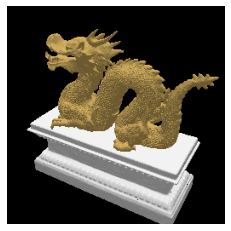

In [7]:
plt.imshow(images_ref[0].cpu().detach().numpy().transpose(1,2,0)[:,:,:3])
plt.axis('off')

## MLP

In [8]:
device = 'cuda'
aggr_func = 'probabilistic'
squared = False
dist_shape = 0.0
dist_shift = 0.0
t_conorm_p = 0.0
losses = ['iou']
dist_eps = 100
gif = True
seed = 0
batch_size = 24
image_size = 64#256
mesh_location = os.path.join('data/pose', model_obj)
num_steps = 150
optimizer_choice = 'adam'
learning_rate = 0.5

dist_func = 'mlp'
weights = list(torch.load("data/pose/original_mlp/a15-35-liou_spot.pth").values())
w1 = weights[2]
w2 = weights[3]
w3 = weights[4]
w4 = weights[5]
w5 = weights[6]

####################################################################################################################

lighting = metaras.Lighting()
diff_renderer = metaras.MetaRas(
    image_size=image_size,
    dist_func=dist_func,
    dist_scale=torch.nn.Parameter(torch.tensor([-4.]).to(device)),
    dist_scale_rgb=torch.nn.Parameter(torch.tensor([-4.]).to(device)),
    dist_squared=squared,
    dist_shape=dist_shape,
    dist_shift=dist_shift,
    dist_eps=dist_eps,
    aggr_alpha_func=aggr_func,
    aggr_alpha_t_conorm_p=t_conorm_p,
    aggr_rgb_func='hard',
    w1=w1,
    w2=w2,
    w3=w3,
    w4=w4,
    w5=w5,
)
hard_renderer = metaras.MetaRas(
    image_size=image_size,
    dist_func=0,
    dist_scale=torch.tensor([-4.]).to(device),
    dist_squared=True,
    dist_shape=0.,
    dist_shift=0.,
    dist_eps=10,
    aggr_alpha_func=0,
    aggr_alpha_t_conorm_p=0.,
    aggr_rgb_func='hard',
)

res_directory = f'data/pose/transfer_{diff_renderer.dist_func}'
try:
    os.makedirs(res_directory)
except:
    print("directory exists")
    
mesh = metaras.Mesh.from_obj(mesh_location,load_texture=True, texture_res=5, texture_type='surface',normalization = True)
mesh = metaras.Mesh(mesh.vertices.repeat(batch_size, 1, 1), mesh.faces.repeat(batch_size, 1, 1),textures=mesh.textures, texture_res=5, texture_type='surface')

torch.manual_seed(seed)

if gif:
    poses_gt = torch.nn.Parameter(torch.zeros(batch_size, 4).float().to(device))
    poses_gt.data[:, 0] = 2.5 + torch.rand(batch_size) * 1.5
    poses_gt.data[:, 1] = torch.randn(batch_size) * 60
    poses_gt.data[:, 2] = torch.randn(batch_size) * 60
    poses_gt.data[:, 3] = 20.
else:
    poses_gt = torch.nn.Parameter(torch.zeros(batch_size, 4).float().to(device))
    poses_gt.data[:, 0] = 2.5 + 0.5*torch.ones(batch_size) * 1.5
    poses_gt.data[:, 1] = 0.5*torch.ones(batch_size) * 60
    poses_gt.data[:, 2] = 0.5*torch.ones(batch_size) * 60
    poses_gt.data[:, 3] = 20.

print('Generating goals...')
with torch.no_grad():
    goal = render(mesh, poses_gt, hard_renderer)
    
    # uncomment to save the goals
    directory = f'data/pose/transfer_ref'
    try:
        os.makedirs(directory)
    except:
        print("directory exists")
    for i in range(24):
        plt.axis("off")
        plt.imshow(goal[i].cpu().detach().numpy().transpose(1,2,0)[:,:,:3])
        plt.savefig(f'{directory}/ref_{i}.pdf',bbox_inches='tight',pad_inches=0.0)
        plt.clf()

####################################################################################################################

threshold = 5

####################################################################################################################

initial_angles = [
    (15, 35),
#     (35, 55),
#     (55, 75),
]

####################################################################################################################

for initial_angle_min, initial_angle_max in initial_angles:
    for loss_fn in losses:
        grid_x = 4
        grid_y = 6
        setting = 'a{aa}-{ab}-l{l}'.format(
            aa=initial_angle_min,
            ab=initial_angle_max,
            l=loss_fn,
        )

        loop = tqdm(range(num_steps))
        torch.manual_seed(seed+1)
        
        if gif:
            poses = torch.nn.Parameter(torch.zeros(batch_size, 4).float().to(device))
            poses.data[:, 0] = 2. + torch.rand(batch_size) * 8.
            poses.data[:, 1] = torch.randn(batch_size)
            poses.data[:, 2] = torch.randn(batch_size)
            angles = torch.sqrt(poses.data[:, 1] ** 2 + poses.data[:, 2] ** 2)
            initial_angle = initial_angle_min + torch.rand(batch_size).to(device) * (initial_angle_max - initial_angle_min)
            poses.data[:, 1] = poses.data[:, 1] * initial_angle / angles
            poses.data[:, 2] = poses.data[:, 2] * initial_angle / angles
            poses.data[:, 3] = 10. + torch.rand(batch_size) * 20.
        else:
            random_weight = 0.6
            poses = torch.nn.Parameter(torch.zeros(batch_size, 4).float().to(device))
            poses.data[:, 0] = 2. + random_weight*torch.ones(batch_size) * 8.
            poses.data[:, 1] = random_weight*torch.ones(batch_size)
            poses.data[:, 2] = random_weight*torch.ones(batch_size)
            angles = torch.sqrt(poses.data[:, 1] ** 2 + poses.data[:, 2] ** 2)
            initial_angle = initial_angle_min + random_weight*torch.ones(batch_size).to(device) * (initial_angle_max - initial_angle_min)
            poses.data[:, 1] = poses.data[:, 1] * initial_angle / angles
            poses.data[:, 2] = poses.data[:, 2] * initial_angle / angles
            poses.data[:, 3] = 10. + random_weight*torch.ones(batch_size) * 20.
        
        if optimizer_choice == 'adam':
            optim = torch.optim.Adam([{"params": poses, "lr": learning_rate}], betas=(0.9, 0.99))
        elif optimizer_choice == 'sgd':
            optim = torch.optim.SGD([{"params": poses, "lr": learning_rate}])
        else:
            raise ValueError(optimizer_choice)
        
        if gif:
            writer = imageio.get_writer('data/pose/transfer_{}_{}_{}.gif'.format(
                setting, model_obj.split('.')[0], diff_renderer.dist_func
            ), mode='I')
            
        history_loss = []
        history_params = []
        
        for i in loop:
            pred = render(mesh, poses, diff_renderer, additional_poses=poses_gt)
            
            # uncomment to save init
            if i == 0:
                directory = f'data/pose/transfer_init'
                try:
                    os.makedirs(directory)
                except:
                    print("directory exists")
                for i in range(24):
                    plt.axis("off")
                    plt.imshow(pred[i].cpu().detach().numpy().transpose(1,2,0)[:,:,:3])
                    plt.savefig(f'{directory}/init_{i}.pdf',bbox_inches='tight',pad_inches=0.0)
                    plt.clf()

            loss = (mse_loss if loss_fn == 'mse' else iou_loss)(pred[:, 3], goal[:, 3])
            optim.zero_grad()
            loss.backward()
            optim.step()

            if loss.isnan():
                print('Stopping the loop because loss is NaN.')
                break
            if gif:
                if i % 20 == 0:
                    successes = poses.data[:, 1] ** 2 + poses.data[:, 2] ** 2 < threshold ** 2
                    writer.append_data(make_grid(pred, goal, grid_x, grid_y, successes))
            
            history_loss.append(loss.item())
            
            point_gt = metaras.functional.get_points_from_angles(torch.ones_like(poses_gt[:, 0]), torch.zeros_like(poses_gt[:, 1]),torch.zeros_like(poses_gt[:, 2]), degrees=True)
            point = metaras.functional.get_points_from_angles(torch.ones_like(poses[:, 0]), poses[:, 1],poses[:, 2], degrees=True)
            history_params.append(mse_loss(point,point_gt).item())
        
        successes = poses.data[:, 1] ** 2 + poses.data[:, 2] ** 2 < threshold ** 2
        print({'{}_success_{}'.format(setting, threshold): successes.float().mean().item()})
    
        pd_mlp_loss = pd.DataFrame(np.array(history_loss))
        pd_mlp_loss.to_csv(f"{res_directory}/loss_silhouette_{setting}_{model_obj.replace('.obj','')}.csv",header=None,index=False)

        pd_mlp_loss = pd.DataFrame(np.array(history_params))
        pd_mlp_loss.to_csv(f"{res_directory}/loss_param_{setting}_{model_obj.replace('.obj','')}.csv",header=None,index=False)
        
        torch.save(diff_renderer._parameters, f"{res_directory}/{setting}_{model_obj.replace('.obj','')}.pth")

for i in range(24):
    plt.axis("off")
    plt.imshow(pred[i].cpu().detach().numpy().transpose(1,2,0)[:,:,:3])
    plt.savefig(f'{res_directory}/{diff_renderer.dist_func}_{i}.pdf',bbox_inches='tight',pad_inches=0.0)
    plt.clf()

directory exists
Generating goals...
directory exists


  0%|          | 0/150 [00:00<?, ?it/s]

directory exists


100%|██████████| 150/150 [01:38<00:00,  1.52it/s]


{'a15-35-liou_success_5': 0.8333333730697632}


<Figure size 432x288 with 0 Axes>

## Softs

In [9]:
device = 'cuda'
aggr_func = 'probabilistic'
squared = False
dist_shape = 0.0
dist_shift = 0.0
t_conorm_p = 0.0
losses = ['iou']
dist_eps = 100
gif = True
seed = 0
batch_size = 24
image_size = 64#256
mesh_location = os.path.join('data/pose', model_obj)
num_steps = 150
optimizer_choice = 'adam'
learning_rate = 0.5

# funcs = ['gaussian', 'logistic', 'exponential_rev', 'gamma_rev']
funcs = ['gaussian']

for dist_func in funcs:
    if dist_func == 'gamma_rev':
        dist_shape = 0.5
####################################################################################################################

    lighting = metaras.Lighting()
    diff_renderer = metaras.MetaRas(
        image_size=image_size,
        dist_func=dist_func,
        dist_scale=torch.nn.Parameter(torch.tensor([-4.]).to(device)),
        dist_scale_rgb=torch.nn.Parameter(torch.tensor([-4.]).to(device)),
        dist_squared=squared,
        dist_shape=dist_shape,
        dist_shift=dist_shift,
        dist_eps=dist_eps,
        aggr_alpha_func=aggr_func,
        aggr_alpha_t_conorm_p=t_conorm_p,
        aggr_rgb_func='hard',
    )
    hard_renderer = metaras.MetaRas(
        image_size=image_size,
        dist_func=0,
        dist_scale=torch.tensor([-4.]).to(device),
        dist_squared=True,
        dist_shape=0.,
        dist_shift=0.,
        dist_eps=10,
        aggr_alpha_func=0,
        aggr_alpha_t_conorm_p=0.,
        aggr_rgb_func='hard',
    )

    res_directory = f'data/pose/transfer_{diff_renderer.dist_func}'
    try:
        os.makedirs(res_directory)
    except:
        print("directory exists")
        
    mesh = metaras.Mesh.from_obj(mesh_location,load_texture=True, texture_res=5, texture_type='surface', normalization=True)
    mesh = metaras.Mesh(mesh.vertices.repeat(batch_size, 1, 1), mesh.faces.repeat(batch_size, 1, 1),textures=mesh.textures, texture_res=5, texture_type='surface')

    torch.manual_seed(seed)

    if gif:
        poses_gt = torch.nn.Parameter(torch.zeros(batch_size, 4).float().to(device))
        poses_gt.data[:, 0] = 2.5 + torch.rand(batch_size) * 1.5
        poses_gt.data[:, 1] = torch.randn(batch_size) * 60
        poses_gt.data[:, 2] = torch.randn(batch_size) * 60
        poses_gt.data[:, 3] = 20.
    else:
        poses_gt = torch.nn.Parameter(torch.zeros(batch_size, 4).float().to(device))
        poses_gt.data[:, 0] = 2.5 + 0.5*torch.ones(batch_size) * 1.5
        poses_gt.data[:, 1] = 0.5*torch.ones(batch_size) * 60
        poses_gt.data[:, 2] = 0.5*torch.ones(batch_size) * 60
        poses_gt.data[:, 3] = 20.

    print('Generating goals...')
    with torch.no_grad():
        goal = render(mesh, poses_gt, hard_renderer)
        
        # uncomment to save the goals
        # directory = f'data/pose/transfer_ref'
        # try:
        #     os.makedirs(directory)
        # except:
        #     print("directory exists")
        # for i in range(24):
        #     plt.axis("off")
        #     plt.imshow(goal[i].cpu().detach().numpy().transpose(1,2,0)[:,:,:3])
        #     plt.savefig(f'{directory}/ref_{i}.pdf',bbox_inches='tight',pad_inches=0.0)
        #     plt.clf()

    ####################################################################################################################

    threshold = 5

    ####################################################################################################################

    initial_angles = [
        (15, 35),
        # (35, 55),
        # (55, 75),
    ]

    ####################################################################################################################

    for initial_angle_min, initial_angle_max in initial_angles:
        for loss_fn in losses:
            grid_x = 4
            grid_y = 6
            setting = 'a{aa}-{ab}-l{l}'.format(
                aa=initial_angle_min,
                ab=initial_angle_max,
                l=loss_fn,
            )

            torch.manual_seed(seed+1)

            if gif:
                poses = torch.nn.Parameter(torch.zeros(batch_size, 4).float().to(device))
                poses.data[:, 0] = 2. + torch.rand(batch_size) * 8.
                poses.data[:, 1] = torch.randn(batch_size)
                poses.data[:, 2] = torch.randn(batch_size)
                angles = torch.sqrt(poses.data[:, 1] ** 2 + poses.data[:, 2] ** 2)
                initial_angle = initial_angle_min + torch.rand(batch_size).to(device) * (initial_angle_max - initial_angle_min)
                poses.data[:, 1] = poses.data[:, 1] * initial_angle / angles
                poses.data[:, 2] = poses.data[:, 2] * initial_angle / angles
                poses.data[:, 3] = 10. + torch.rand(batch_size) * 20.
            else:
                random_weight = 0.6
                poses = torch.nn.Parameter(torch.zeros(batch_size, 4).float().to(device))
                poses.data[:, 0] = 2. + random_weight*torch.ones(batch_size) * 8.
                poses.data[:, 1] = random_weight*torch.ones(batch_size)
                poses.data[:, 2] = random_weight*torch.ones(batch_size)
                angles = torch.sqrt(poses.data[:, 1] ** 2 + poses.data[:, 2] ** 2)
                initial_angle = initial_angle_min + random_weight*torch.ones(batch_size).to(device) * (initial_angle_max - initial_angle_min)
                poses.data[:, 1] = poses.data[:, 1] * initial_angle / angles
                poses.data[:, 2] = poses.data[:, 2] * initial_angle / angles
                poses.data[:, 3] = 10. + random_weight*torch.ones(batch_size) * 20.

            if optimizer_choice == 'adam':
                optim = torch.optim.Adam([poses], learning_rate, betas=(0.9, 0.99))
            elif optimizer_choice == 'sgd':
                optim = torch.optim.SGD([poses], learning_rate)
            else:
                raise ValueError(optimizer_choice)

            if gif:
                writer = imageio.get_writer('data/pose/transfer_{}_{}_{}.gif'.format(
                    setting, model_obj.split('.')[0], diff_renderer.dist_func
                ), mode='I')

            history_loss = []
            history_params = []

            for i, sigma in zip(tqdm(range(num_steps)), np.linspace(-1, -7, num_steps)):
                diff_renderer.dist_scale = torch.nn.Parameter(torch.tensor([sigma]).float().to(device))

                pred = render(mesh, poses, diff_renderer, additional_poses=poses_gt)
                
                # uncomment to save init
                # if i == 0:
                #     directory = f'data/pose/transfer_init'
                #     try:
                #         os.makedirs(directory)
                #     except:
                #         print("directory exists")
                #     for i in range(24):
                #         plt.axis("off")
                #         plt.imshow(pred[i].cpu().detach().numpy().transpose(1,2,0)[:,:,:3])
                #         plt.savefig(f'{directory}/init_{i}.pdf',bbox_inches='tight',pad_inches=0.0)
                #         plt.clf()
                
                loss = (mse_loss if losses[0] == 'mse' else iou_loss)(pred[:, 3], goal[:, 3])
                optim.zero_grad()
                loss.backward()
                optim.step()

                if loss.isnan():
                    print('Stopping the loop because loss is NaN.')
                    break
                if gif:
                    if i % 20 == 0:
                        successes = poses.data[:, 1] ** 2 + poses.data[:, 2] ** 2 < threshold ** 2
                        writer.append_data(make_grid(pred, goal, grid_x, grid_y, successes))

                history_loss.append(loss.item())

                point_gt = metaras.functional.get_points_from_angles(torch.ones_like(poses_gt[:, 0]), torch.zeros_like(poses_gt[:, 1]),torch.zeros_like(poses_gt[:, 2]), degrees=True)
                point = metaras.functional.get_points_from_angles(torch.ones_like(poses[:, 0]), poses[:, 1],poses[:, 2], degrees=True)
                history_params.append(mse_loss(point,point_gt).item())
            
            successes = poses.data[:, 1] ** 2 + poses.data[:, 2] ** 2 < threshold ** 2
            print({'{}_success_{}'.format(setting, threshold): successes.float().mean().item()})

            pd_mlp_loss = pd.DataFrame(np.array(history_loss))
            pd_mlp_loss.to_csv(f"{res_directory}/loss_silhouette_{setting}_{model_obj.replace('.obj','')}.csv",header=None,index=False)

            pd_mlp_loss = pd.DataFrame(np.array(history_params))
            pd_mlp_loss.to_csv(f"{res_directory}/loss_param_{setting}_{model_obj.replace('.obj','')}.csv",header=None,index=False)
            
    for i in range(24):
        plt.axis("off")
        plt.imshow(pred[i].cpu().detach().numpy().transpose(1,2,0)[:,:,:3])
        plt.savefig(f'{res_directory}/{diff_renderer.dist_func}_{i}.pdf',bbox_inches='tight',pad_inches=0.0)
        plt.clf()

directory exists
Generating goals...


100%|██████████| 150/150 [02:29<00:00,  1.00it/s]


{'a15-35-liou_success_5': 0.5}


<Figure size 432x288 with 0 Axes>